In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import logging
logging.basicConfig(level=os.environ.get("LOGLEVEL", "INFO"))

import pandas as pd

##
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor  

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
import mlflow
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error

import pickle # Read and Save model - Serialization
from datetime import datetime

# custom functions
import sys
sys.path.append("/Users/java/Documents/10Acadamy/week - 3/Rossmann Pharmaceuticals")
from myscripts import util
from myscripts import plot

In [2]:
## Read Datas

train_store_file = '../data/clean_train_store.csv'

In [3]:
train_store_df = pd.read_csv(train_store_file, parse_dates = True, low_memory = False)

### Preprocessing

In [4]:
train_store_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017209 entries, 0 to 1017208
Data columns (total 22 columns):
 #   Column                     Non-Null Count    Dtype  
---  ------                     --------------    -----  
 0   Store                      1017209 non-null  int64  
 1   DayOfWeek                  1017209 non-null  int64  
 2   Date                       1017209 non-null  object 
 3   Sales                      1017209 non-null  int64  
 4   Customers                  1017209 non-null  int64  
 5   Open                       1017209 non-null  int64  
 6   Promo                      1017209 non-null  int64  
 7   StateHoliday               1017209 non-null  object 
 8   SchoolHoliday              1017209 non-null  int64  
 9   Year                       1017209 non-null  int64  
 10  Month                      1017209 non-null  int64  
 11  Day                        1017209 non-null  int64  
 12  WeekOfYear                 1017209 non-null  int64  
 13  StoreType   

In [5]:
# ### columns to use
# columns = ['DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday',
#        'SchoolHoliday', 'Year', 'Month', 'Day', 'WeekOfYear']


## Lable Date and StateHoiday Train
columns = ['Sales','Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

feature_columns = ['Store', 'DayOfWeek', 'Open', 'Promo',  'SchoolHoliday', 'Day', 'WeekOfYear','Month', 'Year', 'StoreType',
              'Assortment','CompetitionDistance', 'Promo2']

sample_size = 10000
sampled_df = train_store_df[columns].sample(sample_size)


## Separet Test and train files
train_x = sampled_df[feature_columns]
train_y = sampled_df[['Sales']]
train_x.head()


,Store,DayOfWeek,Open,Promo,SchoolHoliday,Day,WeekOfYear,Month,Year,StoreType,Assortment,CompetitionDistance,Promo2
819735,899,6,1,0,0,16,11,3,2013,d,a,2590.0,1
201048,222,4,1,0,0,13,24,6,2013,a,a,2170.0,0
683400,751,1,1,1,0,5,19,5,2014,a,a,650.0,0
1013118,1111,2,1,1,0,19,47,11,2013,a,a,1900.0,1
600398,659,3,1,1,0,20,47,11,2013,d,a,1590.0,0


In [6]:
### Label encoding
lb = LabelEncoder()
train_x['StoreType'] = lb.fit_transform(train_x['StoreType'])
train_x['Assortment'] = lb.fit_transform(train_x['Assortment'])

train_x.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 819735 to 599234
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Store                10000 non-null  int64  
 1   DayOfWeek            10000 non-null  int64  
 2   Open                 10000 non-null  int64  
 3   Promo                10000 non-null  int64  
 4   SchoolHoliday        10000 non-null  int64  
 5   Day                  10000 non-null  int64  
 6   WeekOfYear           10000 non-null  int64  
 7   Month                10000 non-null  int64  
 8   Year                 10000 non-null  int64  
 9   StoreType            10000 non-null  int64  
 10  Assortment           10000 non-null  int64  
 11  CompetitionDistance  10000 non-null  float64
 12  Promo2               10000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 1.1 MB


In [7]:
x_scaler = MinMaxScaler()
y_scaler = MinMaxScaler()

X = x_scaler.fit_transform(train_x)
Y = y_scaler.fit_transform(train_y)

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2)


In [9]:
rf_reg = RandomForestRegressor(n_estimators = 8, max_depth=2, random_state=0)
rf_reg.fit(X_train, y_train)

RandomForestRegressor(max_depth=2, n_estimators=8, random_state=0)

In [10]:
score = rf_reg.score(X_test, y_test)
print(f"Prediction Score of the Model is {round(score * 100, 2)}%")

Prediction Score of the Model is 52.62%


In [11]:
def train_model(X, Y, model_type='LinearRegression'):
    model = LinearRegression()
    
    if(model_type == 'RandomForest'):
        model = RandomForestRegressor(n_estimators = 100, max_depth=5, random_state=0)
    
        
    kf = KFold(n_splits=5)
    for train_index, test_index in kf.split(X):
        with mlflow.start_run(run_name=model_type, nested = True):
            X_train, X_test = X[train_index], X[test_index]
            y_train, y_test = Y[train_index], Y[test_index]

            model.fit(X_train, y_train)
            score = model.score(X_test, y_test)
            print(f"Prediction Score of the {model_type} is {round(score * 100, 2)}%")
            
            if(model_type == 'LinearRegression'):
                mlflow.log_param('LR-Score', score)
                
            if(model_type == 'RandomForest'):
                mlflow.log_param('RF-Score', score)
                
            mlflow.sklearn.log_model(model, model_type +' Model')
            mlflow.end_run()
            
    print()

## Running this code will create multiple mflow models 
## Create a branch before running this file

# train_model(X, Y, "RandomForest")
# train_model(X, Y)

### Building models with sklearn pipelines

In [12]:
## Prepare the training and test features
x = train_x
y = train_y

X_train, X_test, y_train, y_test = train_test_split(x, y,test_size=0.2)

In [33]:
### Pipe Lines ###

rfr = Pipeline(steps=[
    ('scaler1', StandardScaler()),
    ('rfr_regretion', RandomForestRegressor(n_estimators = 8, max_depth=20, random_state=0))
])

lr = Pipeline(steps=[
    ('scaler2', StandardScaler()),
    ('lr_regretion', LinearRegression())
])

dt = Pipeline(steps=[
    ('scaler3', StandardScaler()),
    ('dt_regretion', DecisionTreeRegressor(random_state = 0)  )
])


In [34]:
rfr.fit(X_train, y_train)
lr.fit(X_train, y_train)
dt.fit(X_train, y_train)

Pipeline(steps=[('scaler3', StandardScaler()),
                ('dt_regretion', DecisionTreeRegressor(random_state=0))])

In [35]:
rfr_score = rfr.score(X_test, y_test)
lr_score = lr.score(X_test, y_test)
dt_score = dt.score(X_test, y_test)

print(f"Prediction Score of the RandomForestRegretion is {round(rfr_score * 100, 2)}%")
print(f"Prediction Score of the LinearRegretion is {round(lr_score * 100, 2)}%")
print(f"Prediction Score of the DecisionTree is {round(dt_score * 100, 2)}%")

# print(rfr_score)

Prediction Score of the RandomForestRegretion is 68.44%
Prediction Score of the LinearRegretion is 51.76%
Prediction Score of the DecisionTree is 49.87%


### Choose a loss function

In [27]:
rfr_prediction = rfr.predict(X_test)
lr_prediction = lr.predict(X_test)
dt_prediction = dt.predict(X_test)

rfr_rmse, rft_mae, _ = util.eval_metrics(y_test, rfr_prediction)
lr_rmse, lr_mae, _ = util.eval_metrics(y_test, lr_prediction)
dt_rmse, dt_mae, _ = util.eval_metrics(y_test, dt_prediction)


# print(f"Mean Absolute Loss : {round(mae * 100, 2)}%")
print(f"RandomForest Mean Square Loss : {round(rfr_rmse * 100, 2)}%")
print(f"Linear Mean Square Loss : {round(lr_rmse * 100, 2)}%")
print(f"DecisionTree Mean Square Loss : {round(dt_rmse * 100, 2)}%")

RandomForest Mean Square Loss : 220248.5%
Linear Mean Square Loss : 272299.09%
DecisionTree Mean Square Loss : 277586.61%


### Post Prediction analysis

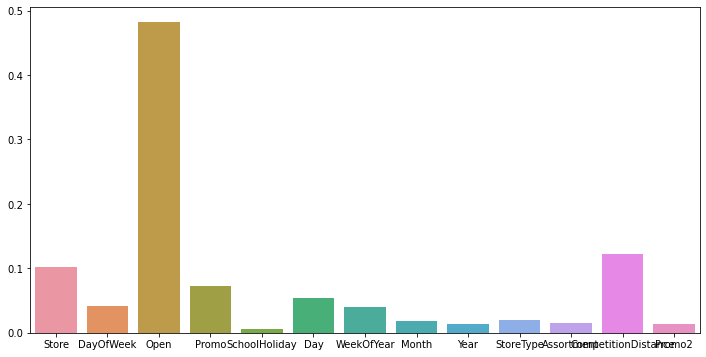

In [28]:

important_features = rfr[1].feature_importances_
plot.bar(feature_columns, important_features)

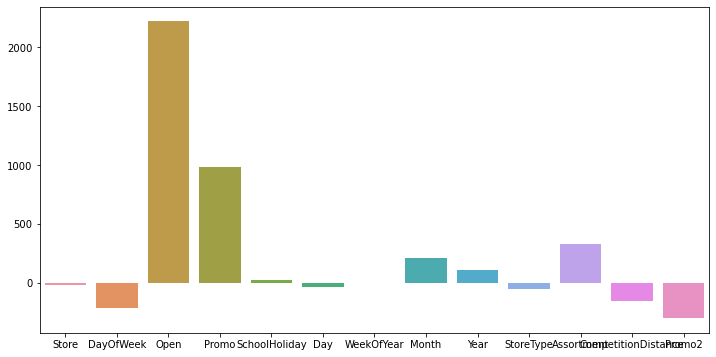

In [29]:
important_features = lr[1].coef_[0]
from matplotlib import pyplot as plt
plot.bar(feature_columns, list(important_features))

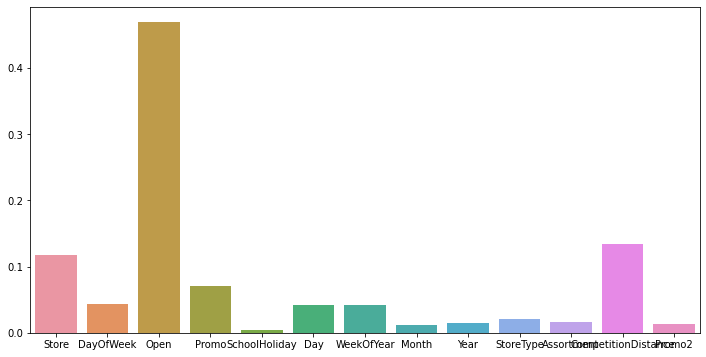

In [19]:
important_features = dt[1].feature_importances_
plot.bar(feature_columns, important_features)

### Serialize models

In [20]:
## use picke to dump mode
## decomment picke to save the model

reg_model_file_name = f'../models/reg-{datetime.now()}.pkl'
lr_model_file_name = f'../models/lt-{datetime.now()}.pkl'
dt_model_file_name = f'../models/dt-{datetime.now()}.pkl'

files = [reg_model_file_name, lr_model_file_name, dt_model_file_name]
models = [rfr, lr, dt]

print(reg_model_file_name)


# for i in range(len(files)):
#         pickle.dump(models[i], open(files[i], 'wb'))

../models/reg-2021-07-30 15:01:46.929467.pkl


In [21]:
### Add the mlflow here


In [22]:
dt_file = '../models/dt-2021-07-30 09:51:48.726269.pkl'
lr_file = '../models/lt-2021-07-30 12:04:14.474722.pkl'
model = pickle.load(open(lr_file, 'rb'))

In [23]:
score = model.score(X_test, y_test)
score

0.5128865203512192